In [13]:
from pathlib import Path
import yaml
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import wilcoxon

PRED_PATH = Path().resolve() / "ax_runs" / "prediction"
STFS_PATH = Path().resolve() / "ax_runs" / "st_sweep"

##### Plot 1: Regression performance

In [14]:
# load regression results
reg_res = defaultdict(dict)

for method_dir in PRED_PATH.iterdir():
    if method_dir.is_dir():
        for dataset_dir in method_dir.iterdir():
            if dataset_dir.is_dir():
                with open(dataset_dir / "metadata.yaml", "r") as f:
                    reg_res[method_dir.name][dataset_dir.name] = yaml.safe_load(f)

reg_res = dict(reg_res)

In [15]:
shared_datasets = [set(v.keys()) for k, v in reg_res.items() if len(v) == 65]
shared_datasets = set.intersection(*shared_datasets)

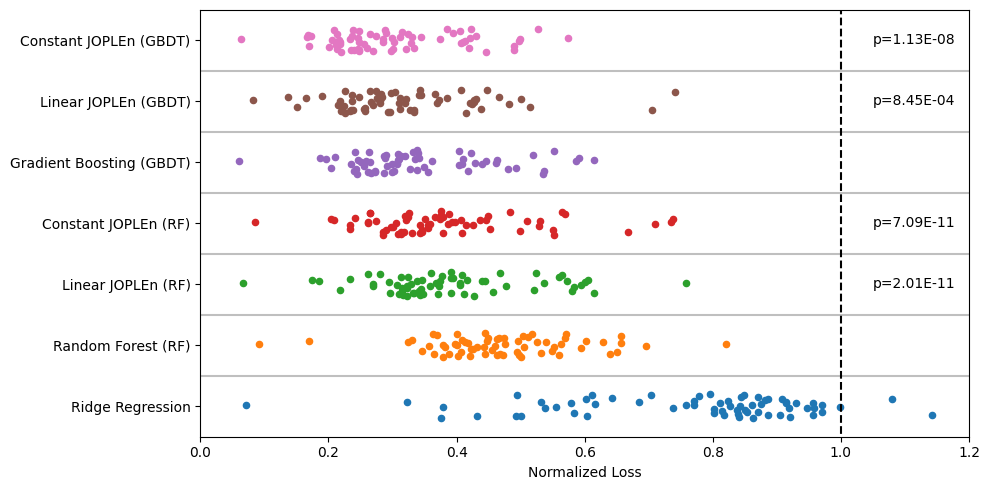

In [16]:
def plot_strip(
    arr: list[np.ndarray],
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
):
    """
    Create a strip plot based on the list of y-values.
    """
    fig, ax = plt.subplots(**plot_kwargs)

    for x_idx, x_values in enumerate(arr):
        np.random.seed(random_state)
        # Apply jitter to x-axis positions
        y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in x_values]
        ax.scatter(x_values, y_values, **scatter_kwargs)

    x_lim = ax.get_xlim()

    for x_idx, x_values in enumerate(arr[:-1]):
        ax.hlines(x_idx + 1 / 2, x_lim[0] - 1, x_lim[1] + 1, color="k", alpha=0.25)

    ax.set_xlim(x_lim)

    return ax


y_labels = [
    "gb",
    "rf",
    "ridge",
    "jp_const_gb_part",
    "jp_const_rf_part",
    "jp_linear_gb_part",
    "jp_linear_rf_part",
]

renamer = {
    "gb": "Gradient Boosting (GBDT)",
    "rf": "Random Forest (RF)",
    "ridge": "Ridge Regression",
    "jp_const_gb_part": "Constant JOPLEn (GBDT)",
    "jp_const_rf_part": "Constant JOPLEn (RF)",
    "jp_linear_gb_part": "Linear JOPLEn (GBDT)",
    "jp_linear_rf_part": "Linear JOPLEn (RF)",
}

x_values = []

for method in y_labels:
    tmp_x_values = []
    for k, v in reg_res[method].items():
        if k in shared_datasets:
            tmp_x_values.append(v["test_score"] / v["dummy_loss"])

    x_values.append(tmp_x_values)

argsort = np.argsort([np.mean(x) for x in x_values])[::-1]
x_values = [x_values[i] for i in argsort]
y_labels = [y_labels[i] for i in argsort]

# compute p values
pval_groups = {
    "gb": [
        "jp_const_gb_part",
        "jp_linear_gb_part",
    ],
    "rf": [
        "jp_const_rf_part",
        "jp_linear_rf_part",
    ],
}

pvals = {}

for original, group in pval_groups.items():
    orig_idx = y_labels.index(original)
    for refit_method in group:
        refit_idx = y_labels.index(refit_method)

        pvals[refit_method] = wilcoxon(
            x_values[orig_idx],
            x_values[refit_idx],
            alternative="greater",
        ).pvalue

ax = plot_strip(
    x_values,
    plot_kwargs=dict(figsize=(10, 5)),
    scatter_kwargs=dict(s=20, alpha=1.0),
)

# add pvalues to the right side of the plot
for i, group in enumerate(y_labels):
    if group in pvals:
        ax.text(
            1.05,
            i,
            f"p={pvals[group]:.2E}",
            horizontalalignment="left",
            verticalalignment="center",
        )

ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels([renamer[y] for y in y_labels])

ax.set_xticks(np.arange(0, 1.3, 0.2))

y_lim = ax.get_ylim()
ax.vlines(1, -1, len(y_labels) + 1, color="k", linestyle="--")
ax.set_ylim(-1 / 2, len(y_labels) - 1 / 2)

plt.xlabel("Normalized Loss")

plt.tight_layout()
plt.savefig("plots/fig1.pdf")

plt.show()

##### Figure 2: Feature selection

In [19]:
# load data

st_sel_res = defaultdict(lambda: defaultdict(list))

for method_dir in STFS_PATH.iterdir():
    if method_dir.is_dir():
        for dataset_dir in method_dir.iterdir():
            if dataset_dir.is_dir():
                metadata = defaultdict(list)
                for file in dataset_dir.iterdir():
                    if file.suffix == ".yaml":
                        with open(file, "r") as f:
                            file_content = yaml.safe_load(f)

                        density = file_content["model"]["results"]["density"]
                        metadata["density"].append(density)

                        test_err = file_content["model"]["score"]["norm_error"]["test"]
                        metadata["error"].append(test_err)

                st_sel_res[method_dir.name][dataset_dir.name] = dict(metadata)

for k, v in st_sel_res.items():
    st_sel_res[k] = dict(v)

st_sel_res = dict(st_sel_res)

In [21]:
def pareto_front(
    score: np.ndarray, density: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    unique_density = np.unique(density)

    pareto_score = []
    pareto_density = []

    for d in unique_density:
        mask = density == d
        pareto_score.append(np.min(score[mask]))
        pareto_density.append(d)

    pareto_score = np.array(pareto_score)
    pareto_density = np.array(pareto_density)

    args = np.argsort(pareto_density)

    return pareto_density[args], pareto_score[args]

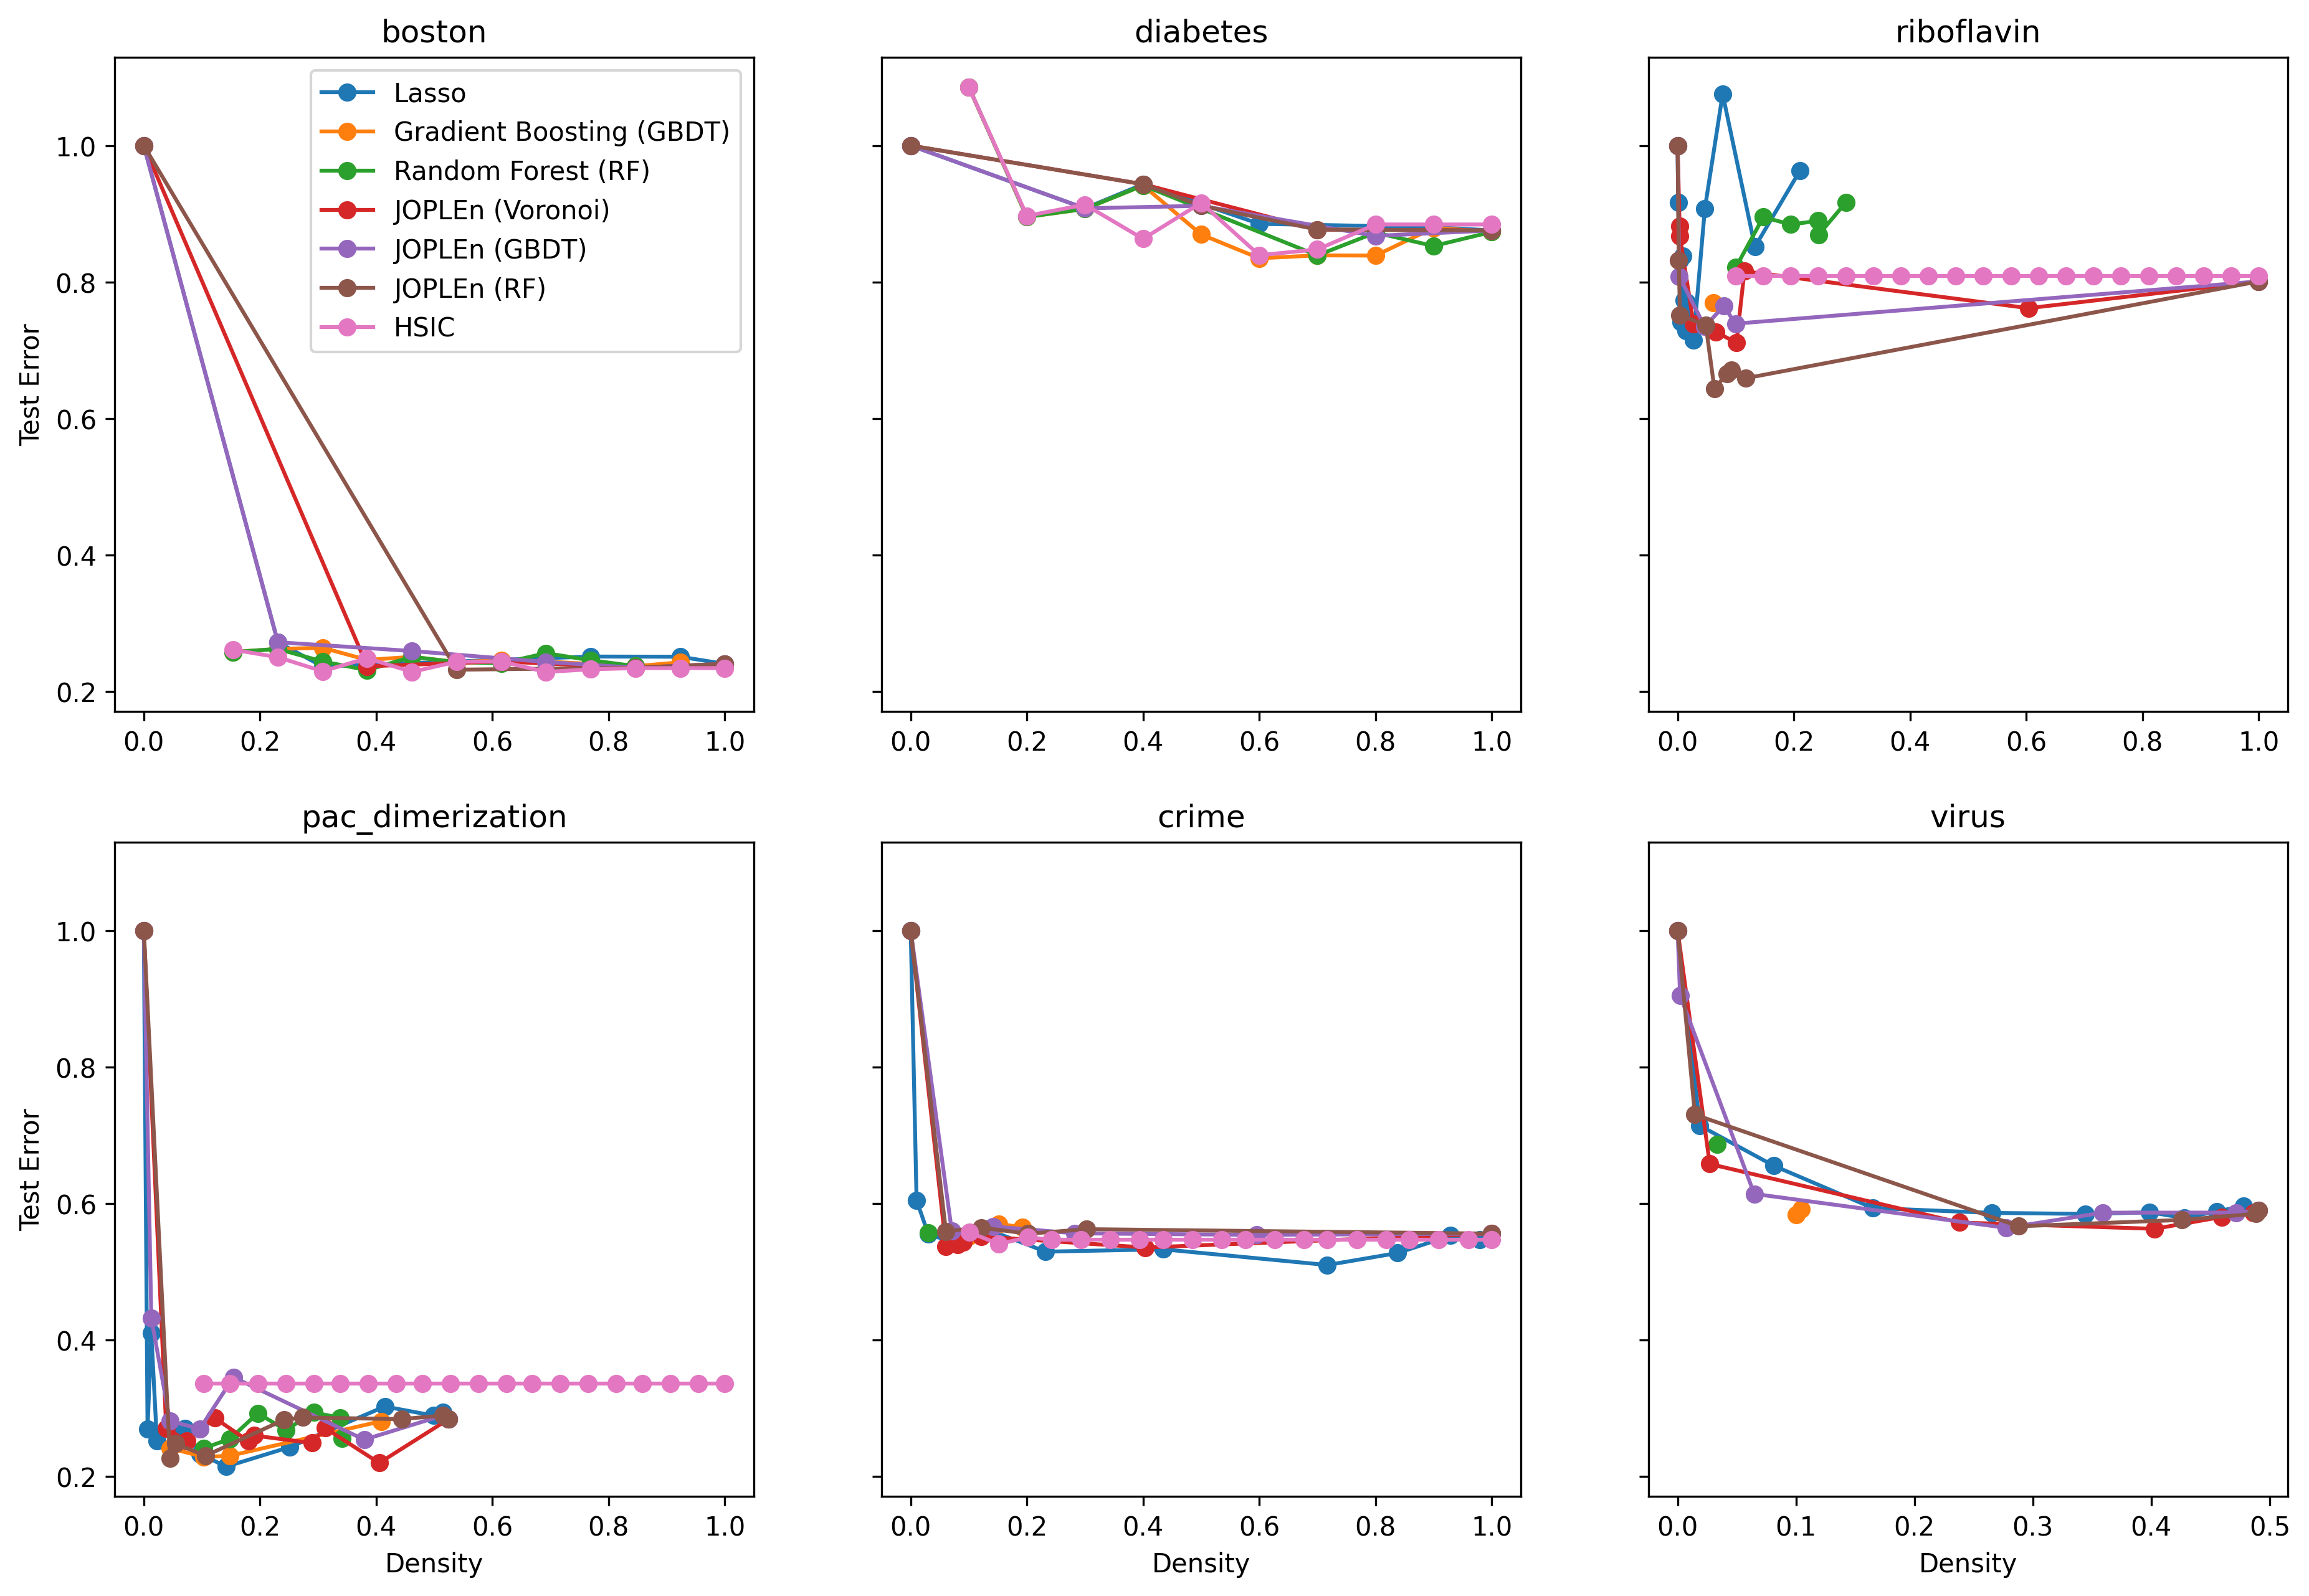

In [32]:
LST_DATASETS = [
    "boston",
    "diabetes",
    "riboflavin",
    "pac_dimerization",
    "crime",
    "virus",
]

LST_METHODS = [
    "lasso",
    "gb",
    "rf",
    "jp_linear_mu",
    "jp_linear_gb_part",
    "jp_linear_rf_part",
    "hsic",
]

renamer = {
    "lasso": "Lasso",
    "gb": "Gradient Boosting (GBDT)",
    "rf": "Random Forest (RF)",
    "hsic": "HSIC",
    "jp_linear_mu": "JOPLEn (Voronoi)",
    "jp_linear_gb_part": "JOPLEn (GBDT)",
    "jp_linear_rf_part": "JOPLEn (RF)",
}


n_ds = len(LST_DATASETS)

fig, axs = plt.subplots(2, n_ds // 2, figsize=(5 * n_ds // 2, 10), sharey=True, dpi=300)

for ax, ds in zip(axs.ravel(), LST_DATASETS):
    for k in LST_METHODS:
        if ds not in st_sel_res[k]:
            continue

        model_score = np.array(st_sel_res[k][ds]["error"])
        model_density = np.array(st_sel_res[k][ds]["density"])

        pareto_density, pareto_score = pareto_front(model_score, model_density)
        ax.plot(pareto_density, pareto_score, label=renamer[k], marker="o")

    ax.set_title(ds)

axs[0, 0].legend()

for ax in axs.T:
    ax[1].set_xlabel("Density")

for ax in axs:
    ax[0].set_ylabel("Test Error")

plt.savefig("plots/fig2.pdf")
plt.show()